In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2

from camera import Camera
import structure
import processor
import features

In [2]:
img1 = cv2.imread('../eigenerAnsatz/bildverband2/DJI_0289.JPG')
img2 = cv2.imread('../eigenerAnsatz/bildverband2/DJI_0288.JPG')
img3 = cv2.imread('../eigenerAnsatz/bildverband2/DJI_0287.JPG')
print("Bilder geladen")

Bilder geladen


In [3]:
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(
    cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
kp2, des2 = sift.detectAndCompute(
    cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)
kp3, des3 = sift.detectAndCompute(
    cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY), None)

kp1 = np.array([n.pt for n in kp1])
kp2 = np.array([n.pt for n in kp2])
kp3 = np.array([n.pt for n in kp3])


In [4]:
def matchPoints(kp1,des1,kp2,des2):
    # Find point matches
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=100)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's SIFT matching ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)

    paare = np.array([[m.queryIdx, m.trainIdx] for m in good])
    
    # Constrain matches to fit homography
    retval, mask = cv2.findHomography(
        kp1[paare[:, 0]], kp2[paare[:, 1]], cv2.RANSAC, 100.0)
    mask = mask.ravel()

    # We select only inlier points
    paare = paare[mask == 1]
    return paare

In [5]:
paare = matchPoints(kp1, des1, kp2, des2)
paare2 = matchPoints(kp2[paare[:, 1]], des2[paare[:, 1]], kp3, des3)


In [6]:
pts1 = kp1[paare[:,0]].T
pts2 = kp2[paare[:,1]].T
pts3 = kp3[paare2[:,1]].T

In [7]:
points1 = processor.cart2hom(pts1)
points2 = processor.cart2hom(pts2)
points3 = processor.cart2hom(pts3)


/tmp/ipykernel_27781/1064300948.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


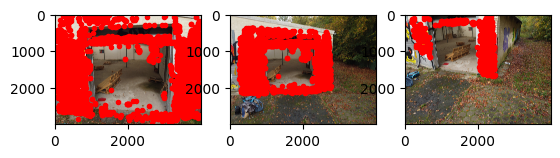

In [9]:
fig, ax = plt.subplots(1, 3)
ax[0].autoscale_view('tight')
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].plot(points1[0], points1[1], 'r.')
ax[1].autoscale_view('tight')
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].plot(points2[0], points2[1], 'r.')
ax[2].autoscale_view('tight')
ax[2].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax[2].plot(kp3[paare2[:, 1], 0], kp3[paare2[:, 1], 1], 'r.')
fig.show()

In [187]:
height, width, ch = img1.shape
intrinsic = np.array([  # for dino
    [2666, 0, width / 2],
    [0, 2666, height / 2],
    [0, 0, 1]])
intrinsic

array([[2.666e+03, 0.000e+00, 2.000e+03],
       [0.000e+00, 2.666e+03, 1.500e+03],
       [0.000e+00, 0.000e+00, 1.000e+00]])

In [188]:
def scale_and_translate_points(points):
    """ Scale and translate image points so that centroid of the points
        are at the origin and avg distance to the origin is equal to sqrt(2).
        Hartley p109
    :param points: array of homogenous point (3 x n)
    :returns: array of same input shape and its normalization matrix
    """
    x = points[0]
    y = points[1]
    center = points.mean(axis=1)  # mean of each row
    cx = x - center[0]  # center the points
    cy = y - center[1]
    dist = np.sqrt(np.power(cx, 2) + np.power(cy, 2))
    scale = np.sqrt(2) / dist.mean()
    norm3d = np.array([
        [scale, 0, -scale * center[0]],
        [0, scale, -scale * center[1]],
        [0, 0, 1]
    ])

    return np.dot(norm3d, points), norm3d


In [189]:
def correspondence_matrix(p1, p2):
    """Each row in the A matrix below is constructed as
        [x'*x, x'*y, x', y'*x, y'*y, y', x, y, 1]
        Hartley p279"""
    p1x, p1y = p1[:2]
    p2x, p2y = p2[:2]

    return np.array([
        p1x * p2x, p1x * p2y, p1x,
        p1y * p2x, p1y * p2y, p1y,
        p2x, p2y, np.ones(len(p1x))
    ]).T


In [190]:
def compute_essential_normalized(p1, p2):
    """ Computes the fundamental or essential matrix from corresponding points
        using the normalized 8 point algorithm.
        Hartley p294
    :input p1, p2: corresponding points with shape 3 x n
    :returns: fundamental or essential matrix with shape 3 x 3
    """
    n = p1.shape[1]
    if p2.shape[1] != n:
        raise ValueError('Number of points do not match.')

    # preprocess image coordinates
    # Hartley p282
    p1n, T1 = scale_and_translate_points(p1)
    p2n, T2 = scale_and_translate_points(p2)

    # compute F or E with the coordinates
    # Harley p280
    A = correspondence_matrix(p1n, p2n)
    # compute linear least square solution
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # constrain F. Make rank 2 by zeroing out last singular value
    # Hartley p. 259
    U, S, V = np.linalg.svd(F)
    # S[-1] = 0 # Fundamental Hartley p.281
    S = [1, 1, 0]  # Force rank 2 and equal eigenvalues
    F = U @ np.diag(S) @ V

    # reverse preprocessing of coordinates
    # We know that P1' E P2 = 0
    # Hartley p282
    F = T1.T@F@T2

    return F / F[2, 2]


In [191]:
# Calculate essential matrix with 2d points.
# Result will be up to a scale
# First, normalize points
# Hartley p257
points1n = np.dot(np.linalg.inv(intrinsic), points1)
points2n = np.dot(np.linalg.inv(intrinsic), points2)
#cv2.undistortPoints(pts1, intrinsic, None)[:,0,:].T

In [192]:
E = compute_essential_normalized(points1n, points2n)
#E1 = structure.compute_essential_normalized(points1n, points2an)
print('Computed essential matrix:', (-E / E[0][1]))


Computed essential matrix: [[-3.15754246e-02 -1.00000000e+00 -2.56696028e-01]
 [ 9.58704647e-01 -1.26424200e-02  8.88458534e-05]
 [ 2.88114366e-01  2.32508794e-01  6.06601261e-02]]


In [193]:
cv2.__version__
cv2E,cv2mask = cv2.findEssentialMat(pts1.T,pts2.T,intrinsic)

In [194]:
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P1

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0]])

In [195]:
_,R,t,_= cv2.recoverPose(E,pts1.T,pts2.T, intrinsic)
R = np.linalg.inv(R)
t = -R@t
P2 = np.c_[R,t]
P2


array([[ 0.97444144,  0.0521294 , -0.21850951, -0.00336718],
       [-0.04503085,  0.99828733,  0.0373448 , -0.2485339 ],
       [ 0.22008204, -0.02655065,  0.97511997,  0.96861734]])

In [219]:
points2n[:2].T

array([[-0.64935154, -0.65069277, -0.64831596, ...,  0.27313924,
         0.28143599,  0.27039188],
       [-0.27341099, -0.19356812, -0.26408925, ..., -0.11074589,
         0.01709694, -0.16008496]])

In [221]:
_,R,t,_= cv2.recoverPose(E,points1n[:2].T, points2n[:2].T)
R = np.linalg.inv(R)
t = -R@t
P2 = np.c_[R, t]
P2


array([[ 0.97444144,  0.0521294 , -0.21850951, -0.00336718],
       [-0.04503085,  0.99828733,  0.0373448 , -0.2485339 ],
       [ 0.22008204, -0.02655065,  0.97511997,  0.96861734]])

In [196]:
tripoints3d = structure.reconstruct_points(points1n, points2n, P1, P2)
#tripoints3d = structure.linear_triangulation(points1n, points2n, P1, P2)


In [197]:
%matplotlib qt
fig = plt.figure()
fig.suptitle('3D reconstructed', fontsize=16)
ax = fig.add_subplot(projection='3d')
ax.plot(tripoints3d[0], tripoints3d[1], tripoints3d[2], 'r.')
ax.plot([0], [0], [0], 'g.')
ax.plot(-P2[0, 3], -P2[1, 3], -P2[2, 3], 'g.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.axis('square')
ax.set_ylim([-1, 2])
ax.set_xlim([-1, 2])
ax.set_zlim([-1, 2])
plt.show()

qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [198]:
tripoints3d[:,paare2[:,0]].T

array([[-1.09314755, -0.27931835,  1.47116565,  1.        ],
       [-1.05746821, -0.47037079,  1.43888271,  1.        ],
       [-1.04996903, -0.51556372,  1.43263649,  1.        ],
       ...,
       [ 1.02456255, -0.1689901 ,  1.37387851,  1.        ],
       [ 1.02855111, -0.04014862,  1.37979282,  1.        ],
       [ 1.02510663, -0.1647209 ,  1.37342382,  1.        ]])

In [199]:
retval, r2,t2,_ = cv2.solvePnPRansac(tripoints3d[:3,paare2[:,0]].T, kp3[paare2[:,1]], intrinsic, None)
retval, r2,t2

(True,
 array([[0.18382961],
        [0.23114216],
        [0.06734857]]),
 array([[-0.95975861],
        [-0.37685316],
        [ 0.8876921 ]]))

In [200]:
R2,_ = cv2.Rodrigues(r2)
P3 = np.c_[R2,t2]
P3

array([[ 0.97123966, -0.04523991,  0.23376671, -0.95975861],
       [ 0.08740678,  0.98098151, -0.17330702, -0.37685316],
       [-0.22148042,  0.18875545,  0.95672243,  0.8876921 ]])

In [201]:
points3n = np.dot(np.linalg.inv(intrinsic), points3)
points3n


array([[-0.67131245, -0.67792652, -0.67900119, ...,  0.15475136,
         0.15837437,  0.15512802],
       [-0.40379972, -0.49215729, -0.51354701, ..., -0.35468617,
        -0.28742586, -0.35241578],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

In [202]:
tripoints3d2 = structure.linear_triangulation(
    points2n.T[paare2[:, 0]].T, points3n, P2, P3)
tripoints3d2.shape

(4, 651)

In [203]:
%matplotlib qt
fig = plt.figure()
fig.suptitle('3D reconstructed', fontsize=16)
ax = fig.add_subplot(projection='3d')
ax.plot(tripoints3d[0], tripoints3d[1], tripoints3d[2], 'r.')
ax.plot(tripoints3d2[0], tripoints3d2[1], tripoints3d2[2], 'b.')
ax.plot([0], [0], [0], 'g.')
ax.plot(-P2[0, 3], -P2[1, 3], -P2[2, 3], 'g.')
ax.plot(-t2[0], -t2[1], -t2[2], 'g.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.axis('square')
ax.set_ylim([-1, 1])
ax.set_xlim([-1, 1])
ax.set_zlim([-1, 2])
plt.show()


qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


## Some more points

In [204]:
paare3 = matchPoints(kp2, des2, kp3, des3)


In [205]:
pts2_3 = kp2[paare3[:, 0]].T
pts3_2 = kp3[paare3[:, 1]].T
points2_3 = processor.cart2hom(pts2_3)
points3_2 = processor.cart2hom(pts3_2)
points2_3n = np.dot(np.linalg.inv(intrinsic), points2_3)
points3_2n = np.dot(np.linalg.inv(intrinsic), points3_2)


In [206]:
fig, ax = plt.subplots(1, 3)
ax[0].autoscale_view('tight')
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].plot(points1[0], points1[1], 'r.')
ax[1].autoscale_view('tight')
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].plot(points2[0], points2[1], 'r.')
ax[2].autoscale_view('tight')
ax[2].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax[2].plot(kp3[paare2[:, 1], 0], kp3[paare2[:, 1], 1], 'r.')
ax[1].plot(points2_3[0], points2_3[1], 'b.')
ax[2].plot(points3_2[0], points3_2[1], 'b.')
fig.show()


qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [207]:
tripoints3d2 = structure.linear_triangulation(
    points2_3n, points3_2n, P2, P3)
tripoints3d2.shape

(4, 1721)

In [208]:
%matplotlib qt
fig = plt.figure()
fig.suptitle('3D reconstructed', fontsize=16)
ax = fig.add_subplot(projection='3d')
ax.plot(tripoints3d[0], tripoints3d[1], tripoints3d[2], 'r.')
ax.plot(tripoints3d2[0], tripoints3d2[1], tripoints3d2[2], 'b.')
ax.plot([0], [0], [0], 'g.')
ax.plot(-P2[0, 3], -P2[1, 3], -P2[2, 3], 'g.')
ax.plot(-t2[0], -t2[1], -t2[2], 'g.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.axis('square')
ax.set_ylim([-1, 1])
ax.set_xlim([-1, 1])
ax.set_zlim([-1, 2])
plt.show()


qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [209]:
img4 = cv2.imread('../eigenerAnsatz/bildverband2/DJI_0286.JPG')
kp4, des4 = sift.detectAndCompute(
    cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY), None)
kp4 = np.array([n.pt for n in kp4])

paare4 = matchPoints(kp3, des3, kp4, des4)

[ WARN:0@11196,679] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../eigenerAnsatz/bildverband2/DJI_0286.JPG'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:

pts3_4 = kp3[paare4[:, 0]].T
pts4_3 = kp4[paare4[:, 1]].T
points3_4 = processor.cart2hom(pts3_4)
points4_3 = processor.cart2hom(pts4_3)
points3_4n = np.dot(np.linalg.inv(intrinsic), points3_4)
points4_3n = np.dot(np.linalg.inv(intrinsic), points4_3)


In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].autoscale_view('tight')
ax[0].imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax[0].plot(points3_4[0], points3_4[1], 'r.')
ax[1].autoscale_view('tight')
ax[1].imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
ax[1].plot(points4_3[0], points4_3[1], 'r.')
fig.show()


qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


## Bundle Adjustment

In [210]:
from scipy.optimize import least_squares
from scipy.sparse import lil_matrix

In [211]:
r1,_ = cv2.Rodrigues(np.float32(P1[:3, :3]))
t1 = P1[:,3]
r2, _ = cv2.Rodrigues(np.float32(P2[:3, :3]))
t2 = P2[:, 3]
r3, _ = cv2.Rodrigues(np.float32(P3[:3, :3]))
t3 = P3[:, 3]
fx = intrinsic[0,0]
fy = intrinsic[1,1]
cx = intrinsic[0,2]
cy = intrinsic[1,2]

In [ ]:
tripoints3d.shape

In [212]:
x0 = np.hstack((fx,fy,cx,cy,r1.ravel(),t1.ravel(),r2.ravel(),t2.ravel(),r3.ravel(),t3.ravel(),(tripoints3d[:3,:]).T.ravel()))

In [213]:
l = np.hstack((pts1.T.ravel(),pts2.T.ravel(),pts3.T.ravel()))

In [ ]:
def project(x0):
    fx = x0[0]
    fy = x0[1]
    cx = x0[2]
    cy = x0[3]
    
    K = np.array([[fx,0,cx],[0,fy,cy],[0,0,1]])

    r1 = x0[4:7]
    t1 = x0[7:10]
    r2 = x0[10:13]
    t2 = x0[13:16]
    r3 = x0[16:19]
    t3 = x0[19:22]

    coords = x0[22:]
    coords = coords.reshape(len(coords)//3,3)

    p1,_ = cv2.projectPoints(coords, r1,t1,K,None)
    p2, _ = cv2.projectPoints(coords, r2, t2, K, None)
    p3, _ = cv2.projectPoints(coords[paare2[:, 0]], r3, t3, K, None)

    p = np.hstack((p1.ravel(),p2.ravel(),p3.ravel()))
    return p-l


In [214]:
A = lil_matrix((len(l), len(x0)), dtype=int)
print(A.shape)
A[:, :4] = 1
n1 = len(pts1.T)
n3 = len(paare2[:, 0])
for i in range(n1):
    A[2*i:2*i+2, 4:10] = 1
    A[2*i:2*i+2, 22+i*3:25+i*3] = 1

maxy = 0
for i in range(n1):
    A[2*(n1+i):2*(n1+i)+2, 10:16] = 1
    A[2*(n1+i):2*(n1+i)+2, 22+i*3:25+i*3] = 1
    maxy = 25+i*3
print(maxy)

max = 0
for i in range(n3):
    v = n1 + n1
    A[2*(v+i):2*(v+i)+2, 16:22] = 1
    z = paare2[i, 0]
    A[2*(v+i):2*(v+i)+2, 22+z*3:25+z*3] = 1
    max = 2*(v+i)+1
print(max)


(16174, 11176)
11176
16173


In [215]:
res = least_squares(project, x0, jac_sparsity=A, verbose=2,
                    x_scale='jac', method='trf', ftol=1e-3)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1459e+06                                    3.74e+07    
       1              2         8.6522e+05      2.81e+05       4.28e+02       8.02e+07    
       2              3         7.2123e+04      7.93e+05       1.19e+02       1.25e+07    
       3              4         5.0130e+04      2.20e+04       2.53e+01       8.47e+06    
       4              7         4.5211e+04      4.92e+03       1.97e+00       3.91e+06    
       5              9         3.9603e+04      5.61e+03       3.64e+00       1.75e+06    
       6             10         3.4131e+04      5.47e+03       8.42e+00       2.02e+05    
       7             11         3.3808e+04      3.23e+02       1.03e+01       1.03e+06    
       8             13         3.3709e+04      9.93e+01       1.31e+00       2.26e+05    
       9             14         3.3607e+04      1.01e+02       2.27e+00       1.31e+06    

In [216]:
fx = res.x[0]
fy = res.x[1]
cx = res.x[2]
cy = res.x[3]

K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
K

array([[3.02256428e+03, 0.00000000e+00, 1.98994522e+03],
       [0.00000000e+00, 3.09675655e+03, 1.52832775e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
intrinsic

array([[3.03065e+03, 0.00000e+00, 1.99400e+03],
       [0.00000e+00, 3.03065e+03, 1.51700e+03],
       [0.00000e+00, 0.00000e+00, 1.00000e+00]])

In [ ]:
project(res.x)

array([-0.0404609 ,  0.17624789, -0.02722565, ...,  0.41697638,
        0.18808221,  0.08948673])

In [ ]:
project(x0)


array([ 0.1297351 , -8.40141561, -0.82005433, ...,  2.6961935 ,
        0.60731242, -0.56346457])

In [ ]:
coords_new = res.x[22:]
coords_new = coords_new.reshape(len(coords_new)//3,3)

print(t1-res.x[7:10])
print(t2-res.x[13:16])
print(t3-res.x[19:22])


[ 0.03902937 -0.02478732  0.16187788]
[-0.00160075 -0.07985368  0.30009052]
[-0.09842735 -0.02812442  0.29874675]


In [ ]:
coords_new.T

array([[-0.86589095, -0.87965045, -0.8648269 , ...,  0.76293974,
         0.78786404,  0.75477269],
       [-0.34577468, -0.21544822, -0.33023573, ..., -0.03140646,
         0.20167333, -0.11879695],
       [ 1.4599285 ,  1.47767347,  1.45985475, ...,  1.33145649,
         1.36593493,  1.31922673]])

In [ ]:
%matplotlib qt
fig = plt.figure()
fig.suptitle('3D reconstructed', fontsize=16)
ax = fig.add_subplot(projection='3d')
ax.plot(coords_new.T[0], coords_new.T[1], coords_new.T[2], 'r.')
ax.plot(-t1[0], -t1[1], -t1[2], 'g.')
ax.plot(-t2[0], -t2[1], -t2[2], 'g.')
ax.plot(-t3[0], -t3[1], -t3[2], 'g.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.axis('square')
ax.set_ylim([-1, 2])
ax.set_xlim([-1, 2])
ax.set_zlim([-1, 2])
plt.show()


qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [ ]:
print(t1,t2,t3)
t23 = t3-t2
(t23@t23)**0.5

In [ ]:
cv2.stereo.QuasiDenseStereo_create